<a href="https://colab.research.google.com/github/dingowhiz/Data_Analytics_ML/blob/main/mayo_wsi_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

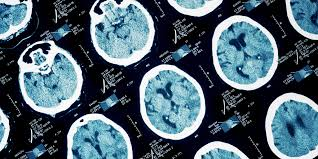
#  Mayo Clinic Image Classification of Stroke Blood Clot Origin   

### Predict the origin of blood clot in ischemic stroke patients using Machine Learning classification models
@author: Russell Tang, Dominador Ramos Jr



## Objective

* Stroke remains the second-leading cause of death worldwide. Each year in the United States, over 700,000 individuals experience an ischemic stroke caused by a blood clot blocking an artery to the brain. A second stroke (23% of total events are recurrent) worsens the chances of the patient’s survival. However, subsequent strokes may be mitigated if physicians can determine stroke etiology, which influences the therapeutic management following stroke events. 
* The objective of this project is to use Machine Learning model/s to predict the presence and origin of either one of the two major acute ischemic stroke (AIS) etiology subtypes: cardiac and large artery atherosclerosis by analysing the digital pathology slides, Whole Slide Images (WSI).
* Tasks include building an image processing pipeline with image loading, segmentation, augmentation and transformation of 724 WSI images and building of a deep learning neural network model https://news.mayocliniclabs.com/2019/10/16/introducing-whole-slide-imaging-to-pathways/

The dataset comprises over a thousand high-resolution whole-slide digital pathology images stained in Hematoxylin and Eosin. The variation of stain intensity is often driven by the pathologist’s learning experience and personal preference. Each slide depicts a blood clot from a patient that had experienced an acute ischemic stroke.

The slides comprising the training and test sets depict clots with an etiology (that is, origin) known to be either CE (Cardioembolic) or LAA (Large Artery Atherosclerosis). We include a set of supplemental slides with a either an unknown etiology or an etiology other than CE or LAA.

Data source consists of four datasets in csv format:-
* train.csv (754 images)
* test.csv (4 images)
* other.csv (396 images)

The expected deliverable of this project is a sample_submission.csv file with the result of the predicted probability values of label CE and LAA:- paient_id, CE, LAA.

This notebook serves as a model for data validation, it starts with image loading, image segmentation, pretrained model loading, model building and training, model validation, model scoring and evaluation.     


---



# Track Datasets

* Given datasets :- train.csv
* **Characteristics or dependent variables:-** image_id, center_id, patient_id, image_num
* **Target feature:-** label CE, LAA



### Import Python dependencies and load dataset 

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c mayo-clinic-strip-ai -p 

In [ ]:
 kaggle competitions download -c 'name-of-competition' -p 'dataset

In [30]:
pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 


# Part I - Data Loading and Model Building

In [2]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import sys
import math, time, random, datetime
#from zipfile import ZipFile
import os, glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,64).__str__()

# Data Manipulation
import numpy as np
import pandas as pd
from numpy import vstack
from numpy import hstack
from pandas.api.types import is_numeric_dtype
import datetime 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import sklearn
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import StandardScaler, RobustScaler
#from sklearn.impute import SimpleImputer
import joblib
from joblib import dump, load

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
plt.style.use('seaborn-whitegrid')

# Preprocessing

import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedKFold

# Machine learning
import tensorflow as tf
#import segmentation_models as sm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import Model
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D, Dense, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten
#from keras.layers import LeakyReLU
#LeakyReLU = LeakyReLU(alpha=0.1)

# Let's ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir ~/.kaggle

In [ ]:
#!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle competitions download -c mayo-clinic-strip-ai -f train.csv

In [4]:
# load dataset                              

df_train = pd.read_csv('/content/drive/MyDrive/Mayo/train.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('Shape of training dataset: ', df_train.shape)
print(df_train.info())
display(df_train.head(3))
print('\n')

Shape of training dataset:  (754, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB
None


,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA


Total no. of patients : 632


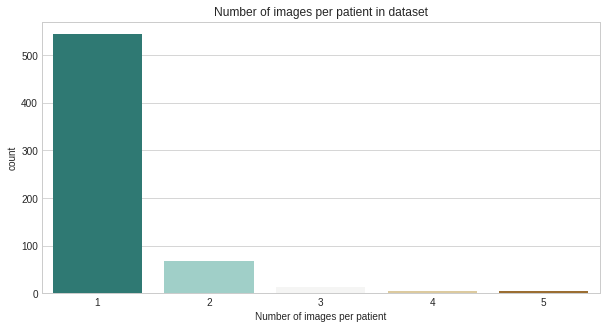

In [ ]:
print('Total no. of patients :', df_train.patient_id.nunique())
plt.figure(figsize=(10,5))
sns.countplot(df_train.groupby("patient_id").image_num.size(), palette="BrBG_r")
plt.xlabel("Number of images per patient")
plt.title("Number of images per patient in dataset");

CE     0.725464
LAA    0.274536
Name: label, dtype: float64

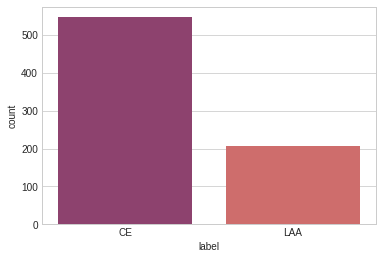

In [ ]:

sns.countplot(df_train.label, palette="flare_r")
df_train.label.value_counts() / df_train.shape[0]

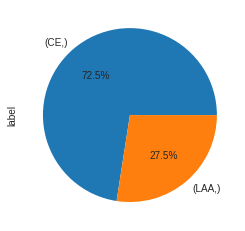

In [ ]:
_=df_train[['label']].value_counts().plot.pie(autopct='%1.1f%%', ylabel='label')

A quick look at the train dataframe does not indicate any blank or null fields in the train dataset but the dataset is imbalanced with the occurence of CE is about 2.6 times that of LAA. 

In [5]:
ce_list = os.listdir('/content/drive/MyDrive/Mayo/train/CE')
laa_list = os.listdir('/content/drive/MyDrive/Mayo/train/LAA')
print(len(ce_list), ',', len(laa_list))
ce_list = [x[:8] for x in ce_list]
laa_list = [x[:8] for x in laa_list]
ce_list[:3]


63 , 58


['112b6e_0', '12c8c9_0', '045eb0_0']

In [6]:
X_ce = df_train[df_train['image_id'].isin(ce_list)]
X_laa = df_train[df_train['image_id'].isin(laa_list)]
X_train = pd.concat([X_ce, X_laa])
X_train.head()

,image_id,center_id,patient_id,image_num,label
1,008e5c_0,11,008e5c,0,CE
4,026c97_0,4,026c97,0,CE
7,032f10_0,7,032f10,0,CE
8,0372b0_0,7,0372b0,0,CE
11,03e6b7_0,7,03e6b7,0,CE


In [7]:
# shuffle training sample datasets
X_train = X_train.sample(frac=1)
X_train.head

<bound method NDFrame.head of      image_id  center_id patient_id  image_num label
72   1764ff_0          4     1764ff          0    CE
266  5619c3_0         11     5619c3          0    CE
149  3152c0_0         10     3152c0          0    CE
100  21b106_0         11     21b106          0    CE
247  516e18_1         10     516e18          1    CE
158  34a278_0          4     34a278          0   LAA
2    00c058_0         11     00c058          0   LAA
271  56d177_3          7     56d177          3    CE
234  4f6fb1_1         10     4f6fb1          1    CE
216  481ba8_0          5     481ba8          0   LAA
42   0c60b8_0          1     0c60b8          0    CE
60   112b6e_0         11     112b6e          0    CE
52   0ed87f_0          2     0ed87f          0    CE
281  5adc4c_0         11     5adc4c          0   LAA
43   0cc0bc_0          4     0cc0bc          0    CE
198  41db5b_0          6     41db5b          0   LAA
11   03e6b7_0          7     03e6b7          0    CE
136  2c8b18_0   

In [7]:
# remove background image
def remove_bkgd(img, mask, threshold=0.990):
  for i in reversed(range(img.shape[1])):      #<--- remove columns
    if (np.sum(mask[:, i]) / float(mask.shape[0])) > threshold:
      img = np.delete(img, i, 1)

  for i in reversed(range(img.shape[0])):      #<--- remove rows
    if (np.sum(mask[i, :]) / float(mask.shape[1])) > threshold:
      img = np.delete(img, i, 0)
  return img

# make mask
def mask_filter(img, val=255):
  masks = [None]*3
  for color in range(3):
    masks[color] = img[..., color] >= np.median(img[:, :, color]) - 5
  mask = np.logical_and(*masks)
  img[mask, :] = val
  return img, mask

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

CE image loading in progress ...:   0%|          | 0/20 [00:00<?, ?it/s]

Loading CE image : 112b6e_0
Loading CE image : 12c8c9_0
Loading CE image : 045eb0_0
Loading CE image : 1295bb_0
Loading CE image : 008e5c_0
Loading CE image : 026c97_0
Loading CE image : 032f10_0
Loading CE image : 0372b0_0
Loading CE image : 09644e_4
Loading CE image : 04439c_0
Loading CE image : 03e6b7_0
Loading CE image : 0aaeb3_0
Loading CE image : 0aff58_0
Loading CE image : 0b7cc8_0
Loading CE image : 0c60b8_0
Loading CE image : 0cc0bc_0
Loading CE image : 0ed87f_0
Loading CE image : 0ed87f_1
Loading CE image : 0ff890_0
Loading CE image : 0ff6fc_0
Total # of CE images loaded :  20


LAA image loading in progress ...:   0%|          | 0/20 [00:00<?, ?it/s]

Loading LAA image : 1f018f_0
Loading LAA image : 244aeb_2
Loading LAA image : 113bb3_0
Loading LAA image : 2a25b9_0
Loading LAA image : 244aeb_1
Loading LAA image : 244aeb_0
Loading LAA image : 0bd414_0
Loading LAA image : 01adc5_0
Loading LAA image : 1db82d_0
Loading LAA image : 1db82d_1
Loading LAA image : 1ffc5d_0
Loading LAA image : 2b7304_0
Loading LAA image : 2b7304_1
Loading LAA image : 23b492_0
Loading LAA image : 162cad_0
Loading LAA image : 00c058_0
Loading LAA image : 0a3ad1_0
Loading LAA image : 0ee750_0
Loading LAA image : 3ee426_0
Loading LAA image : 481ba8_0
Total # of LAA images loaded :  20
Total # of tile images:  17738
Total # of labels :  17738


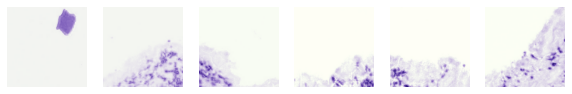

In [20]:
from tqdm.notebook import tqdm_notebook
# file_name = "/content/"
# with ZipFile(file_name,'r') as zip:
#   zip.extractall()
#   print('Done')
#   os.chdir('/content/drive/MyDrive/Mayo/')
ce_path = '/content/drive/MyDrive/Mayo/train/train_CE/'
X = []
y = []
count_CE = 0
count_LAA = 0
os.chdir(ce_path)
img_dir_CE = os.listdir()
img_dir_CE = img_dir_CE[:20]

for ele in tqdm(img_dir_CE, desc = 'CE image loading in progress ...'):
  print('Loading CE image :',ele)
  count_CE+=1
  os.chdir(ce_path + ele )
  cur_dir = os.getcwd()
  if os.path.isdir(cur_dir):
    os.chdir('E_tiles')
    subdir = os.listdir()
    #end = round(len(subdir)/2)
    
    #subdir = subdir[:20]
    
    for s in subdir:
          #print('CE tiles :',s)
      #print('last_dir =',s)
      #print(os.getcwd())
      #print('cur_dir :',cur_dir)
 #     if os.path.isdir(s):
 #       os.chdir(cur_dir+'/'+s+'/E_tiles')
        #print('cur_dir changed to :', os.getcwd())
 #       t_dir = os.listdir()               #<----- load E_tiles images only
 #       for t in t_dir:
          img = cv2.imread(s)  
          #plt.imshow(img)
          #plt.show() 
          img = cv2.resize(img,(224,224))     
          #img, mask = mask_filter(np.array(img))
          #img = remove_bkgd(img, mask)
          X.append(img)
          del img
          y.append('CE')
print('Total # of CE images loaded : ', count_CE)

laa_path = '/content/drive/MyDrive/Mayo/train/train_LAA/'
os.chdir(laa_path)
img_dir_LAA = os.listdir()
img_dir_LAA = img_dir_LAA[:20]

for ele_laa in tqdm(img_dir_LAA, desc = 'LAA image loading in progress ...'):
  print('Loading LAA image :',ele_laa)
  count_LAA+=1
  os.chdir(laa_path + ele_laa)
  cur_dir_laa = os.getcwd()
  if os.path.isdir(cur_dir_laa):
    os.chdir('H_tiles')
    subdir_laa = os.listdir()
    #print(subdir_laa)
    #max = round(len(subdir_laa)/2)
    #subdir_laa = subdir_laa[:20]
    for s_laa in subdir_laa:
          #print('LAA tiles =',s_laa)
      #print(os.getcwd())
      #print('cur_dir :',cur_dir)
  #    if os.path.isdir(s_laa):
  #      os.chdir(cur_dir_laa+'/'+s_laa+'/H_tiles')    #<----- load H_tiles images only
        #print('cur_dir changed to :', os.getcwd())
  #      t_dir_laa = os.listdir()
  #      for t_laa in t_dir_laa:
          img_laa = cv2.imread(s_laa)  
          #plt.imshow(img)
          #plt.show() 
          img_laa = cv2.resize(img_laa,(224,224))      #<=== resize image to 224x224 pixels
          #img, mask = mask_filter(np.array(img))
          #img = remove_bkgd(img, mask)
          X.append(img_laa)
          del img_laa
          y.append('LAA')
     
print('Total # of LAA images loaded : ', count_LAA)
del ce_path, cur_dir, cur_dir_laa, ele, ele_laa, img_dir_CE, img_dir_LAA, laa_path, s, s_laa, subdir, subdir_laa

print('Total # of tile images: ', len(X))
print('Total # of labels : ', len(y))

plt.figure(figsize=(10, 10))
for i in range(6):
      plt.subplot(1, 6, i+1)
      plt.imshow(X[i], cmap="gray")
      plt.axis('off')
plt.show()


In [21]:
print(len(X))
print(type(X[0]))
np.array(X).shape

17738
<class 'numpy.ndarray'>


(17738, 224, 224, 3)

In [22]:
idx = np.random.permutation(len(X))
X2 = [X[j] for j in idx]
y2 = [y[j] for j in idx]

In [23]:
print('before slice :',len(X2), len(y2))
d1=len(X2)//5
d2=len(y2)//5
X3=X2[:d1]
y3=y2[:d2]
del X2, y2
print('after slice :',len(X3), len(y3))
y3[-10:]

before slice : 17738 17738
after slice : 3547 3547


['LAA', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'LAA', 'CE']

In [24]:
y3.count('LAA')

494

In [25]:
X=X3
y=y3
del X3, y3

In [ ]:
#X=X2
#y=y2
#del X2, y2

In [26]:
#y = X_train['label']
y = [0 if x == 'CE' else 1 for x in y]
#y=y.replace('CE', 0)
#y=y.replace('LAA', 1).reset_index(drop=True)



In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape, len(X_train))
print ("Shape of an image in X_test: ", X_test[0].shape)
# le = preprocessing.LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(X_train.shape[0], 224, 224,3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 224, 224,3).astype('float32')
#del X, y
X_train = X_train/224
X_test = X_test/224

#y_train = np.array(y_train)
# X_train = np.array(X_train)
#y_test = np.array(y_test)
# X_test = np.array(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

Shape of an image in X_train:  (224, 224, 3) 2376
Shape of an image in X_test:  (224, 224, 3)
X_train Shape:  (2376, 224, 224, 3)
X_test Shape:  (1171, 224, 224, 3)
y_train Shape:  (2376, 2)
y_test Shape:  (1171, 2)


In [28]:
print(len([y_test[i][0]  for i in range(len(y_test)) if y_test[i][0] == 0]))
print(len([y_test[i][0]  for i in range(len(y_test)) if y_test[i][0] == 1]))

169
1002


In [ ]:
img_temp, mask = mask_filter(np.array(img))
img_temp = remove_bkgd(img, mask)

In [31]:
import segmentation_models as sm
BACKBONE1 ='resnet50'
#BACKBONE2 ='efficientnetb2'
#BACKBONE3 ='inceptionv3'
#BACKBONE4 ='vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE1)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

Segmentation Models: using `keras` framework.


In [32]:
img_rows, img_cols = 224, 224 

sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(BACKBONE1, encoder_weights='imagenet', encoder_freeze=True)
for layer in model.layers:
    layer.trainable = False
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

94601216/94592056 [==============================] - 1s 0us/step
0 InputLayer False
1 BatchNormalization False
2 ZeroPadding2D False
3 Conv2D False
4 BatchNormalization False
5 Activation False
6 ZeroPadding2D False
7 MaxPooling2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 ZeroPadding2D False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 Conv2D False
18 Conv2D False
19 Add False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 ZeroPadding2D False
26 Conv2D False
27 BatchNormalization False
28 Activation False
29 Conv2D False
30 Add False
31 BatchNormalization False
32 Activation False
33 Conv2D False
34 BatchNormalization False
35 Activation False
36 ZeroPadding2D False
37 Conv2D False
38 BatchNormalization False
39 Activation False
40 Conv2D False
41 Add False
42 BatchNormalization False
43 Activation False
44 Conv2D False
4

In [33]:
# Transfer learning, import pretrained VGG16 model
# from keras.applications import vgg16

# vgg = vgg16.VGG16(weights = 'imagenet', 
#                  include_top = False, 
#                  input_shape = (img_rows, img_cols, 3))

# freeze layers
# Layers are set to trainable as True by default
# for layer in vgg.layers:
#     layer.trainable = False
    
# for (i,layer) in enumerate(vgg.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

def lw(bottom_model, num_classes):
    #"""creates the top or head of the model that will be 
    #placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.6)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

num_classes = 2

# FC_Head = lw(vgg, num_classes)
FC_Head = lw(model, num_classes)

# model = Model(inputs = vgg.input, outputs = FC_Head)
model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())
print('Total no. of layers : ',len(model.layers))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [34]:
import gc
collected = gc.collect()
print("Garbage collector: collected", "%d objects." % collected)
del layer
del FC_Head
del BACKBONE1

Garbage collector: collected 18850 objects.


Epoch 1/2
75/75 [==============================] - 1148s 15s/step - loss: 0.4512 - accuracy: 0.8615 - val_loss: 0.4130 - val_accuracy: 0.8557
Epoch 2/2
75/75 [==============================] - 1130s 15s/step - loss: 0.4013 - accuracy: 0.8632 - val_loss: 0.4128 - val_accuracy: 0.8557


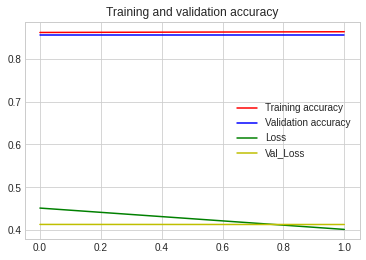

<Figure size 432x288 with 0 Axes>

In [35]:
# Build model
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam"), loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=2, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, val_loss, 'y', label='Val_Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# Build model
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam"), loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=3, 
                    batch_size=64,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, val_loss, 'y', label='Val_Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

ValueError: ignored

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
print(y_predict[:5])
print(len([y_predict[i][0]  for i in range(len(y_predict)) if y_predict[i][0] > 0.90]))
print(y_test[:5])

[[0.92212427 0.07787571]
 [0.92216516 0.07783489]
 [0.9221044  0.07789559]
 [0.92225474 0.07774528]
 [0.9221869  0.0778131 ]]
1086
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_predict)

0.2974619151369204

In [ ]:
#Check model accuracy on the test data
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

#Test a single image
n=2  #Select the index of image to be loaded for testing
img = X_test[n]

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

#Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test))
cm=confusion_matrix(np.argmax(y_test), y_pred)  
sns.heatmap(cm, annot=True)

#############################################################
#Save all images classified as CE so we can fetch these images
#later and plot heatmaps.
########################################################
#Identify all images classified as parasitized
ce_image_idx = np.where(y_pred == 0)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_ce=[]
for i in ce_image_idx:
    ce_img = X_test[i]
    #plt.imsave("results_classified_as_ce/ce_"+str(i)+".png", par_img)
    predicted_as_ce.append(ce_img)
    
predicted_as_ce = np.array(predicted_as_ce)    


34/34 [==============================] - 7s 207ms/step - loss: 0.2975 - accuracy: 0.9125
Accuracy =  91.25230312347412 %
The prediction for this image is:  0
The actual label for this image is:  0


TypeError: ignored

In [ ]:
y_predict[1]


array([0.92216516, 0.07783489], dtype=float32)

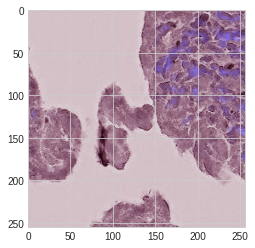

In [ ]:
plt.imshow(img)

In [ ]:
weight_path = '/content/drive/MyDrive/Mayo/Model_Weights'
os.chdir(weight_path)
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("res_cnn.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("res_cnn.h5")
print("Loaded model from disk")

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
T = []
os.chdir('/content/drive/MyDrive/Mayo/test(unseen)')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(224,224))      #<=== resize image to 224x224 pixels
      #img, mask = mask_filter(np.array(img))
      #img = remove_bkgd(img, mask)
      T.append(img)

In [ ]:
class WeightedMultiClassLogarithmicLoss():
    def __init__(self, epsilon=10e-15, weights=np.ones(2, dtype='float64'), class_proportions=np.ones(2, dtype='float64')):
        self.epsilon = epsilon
        self.weights = weights
        self.class_proportions = class_proportions
        #super().__init__()
    
    def call(self, y_true, y_pred):
        print(self.weights)
        print(self.class_proportions)
        print(self.epsilon)
        # probability 𝑝 is replaced with epsilon to avoid extremes of the log function
        y_pred_clipped = k.clip(y_pred, self.epsilon, 1-self.epsilon)
        # ground-truth labels are weighted
        y_true_weighted = (y_true * self.weights)/self.class_proportions
        # compute the log loss
        loss = -1*( k.sum(y_true_weighted * k.log(y_pred_clipped)) / k.sum(self.weights) )
        return loss

In [ ]:
# define the logloss function
weights = np.ones(2, dtype='float64')
weights[0] = 0.5
weights[1] = 0.5
class_counts = X_train.groupby('label')['image_id'].count().values 
class_proportions = class_counts/np.max(class_counts)
k.set_floatx('float64')
log_loss = WeightedMultiClassLogarithmicLoss(epsilon=10e-15, weights=weights, class_proportions=class_proportions)

AttributeError: ignored

# Check Anomaly

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ce_list = os.listdir('/content/drive/MyDrive/Mayo/train/CE')
laa_list = os.listdir('/content/drive/MyDrive/Mayo/train/LAA')
print(len(ce_list), ',', len(laa_list))
ce_list = [x[:8] for x in ce_list]
laa_list = [x[:8] for x in laa_list]
ce_list


21 , 10


['112b6e_0',
 '12c8c9_0',
 '045eb0_0',
 '1295bb_0',
 '008e5c_0',
 '026c97_0',
 '032f10_0',
 '0372b0_0',
 '09644e_4',
 '04439c_0',
 '03e6b7_0',
 '0aaeb3_0',
 '0aff58_0',
 '0b7cc8_0',
 '0c60b8_0',
 '0cc0bc_0',
 '0ed87f_0',
 '0ed87f_1',
 '0ff890_0',
 '0ff6fc_0',
 'ce_patch']

In [ ]:
#Read images and get them ready for training
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add 1 to all parasitized images and 0 to uninfected.
os.chdir('/content/drive/MyDrive/Mayo/train/CE')
ce_images = os.listdir('/content/drive/MyDrive/Mayo/train/CE')

for i, image_name in enumerate(ce_images): 
#Remember enumerate method adds a counter and returns the enumerate object
       print(image_name)
       image = cv2.imread(image_name)
       #image = cv2.resize(image,(224,224))
       # image = np.asarray(image)
       # print('shape of image :', np.uint8(image.shape))
       image = Image.fromarray(image, 'RGB')
       image = image.resize((SIZE, SIZE))
       dataset.append(np.array(image))
       label.append(0)

#Iterate through all images in Uninfected folder, resize to 224x224
#Then save into the same numpy array 'dataset' but with label 0
os.chdir('/content/drive/MyDrive/Mayo/train/LAA')
LAA_images = os.listdir('/content/drive/MyDrive/Mayo/train/LAA')
for i, image_name in enumerate(LAA_images):
        print(i, image_name)
        image = cv2.imread(image_name)
        #image = cv2.resize(image,(224,224))
        # image = np.asarray(image)
        # print('shape of image :', np.uint8(image.shape))
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)

112b6e_0.tif
12c8c9_0.tif
045eb0_0.tif
1295bb_0.tif
008e5c_0.tif
026c97_0.tif
032f10_0.tif
0372b0_0.tif
09644e_4.tif
04439c_0.tif
03e6b7_0.tif
0aaeb3_0.tif
0aff58_0.tif
0b7cc8_0.tif
0c60b8_0.tif
0cc0bc_0.tif
0ed87f_0.tif
0ed87f_1.tif
0ff890_0.tif
0ff6fc_0.tif
0 1f018f_0.tif
1 113bb3_0.tif
2 244aeb_2.tif
3 2a25b9_0.tif
4 15de51_0.tif
5 244aeb_1.tif
6 23b492_0.tif
7 244aeb_0.tif
8 08d3d8_0.tif
9 0ee750_1.tif


In [ ]:
dataset.shape

(30, 224, 224, 3)

In [ ]:
#Split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#Without scaling (normalize) the training may not converge. 
#so that all values are within the range of 0 and 1.
X_train = X_train /255.
X_test = X_test /255.

#Let us setup the model as multiclass with total classes as 2.
#This way the model can be used for other multiclass examples. 
#Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Define Model - use pre-trained VGG16 layers and add GlobalAveragePooling and dense prediction layers.
# >> set the first few convolutional blocks as non-trainable and only train the last block.

def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.009, momentum=0.9), metrics=["accuracy"])
    return model


58900480/58889256 [==============================] - 2s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                    

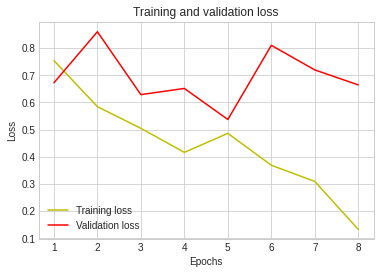

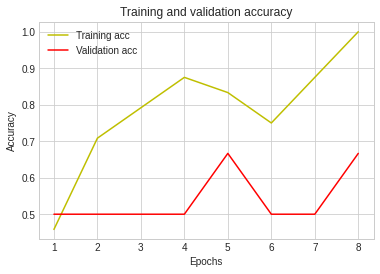

In [ ]:
# Train model
model = get_model(input_shape = (224,224,3))
print(model.summary())

history = model.fit(X_train, y_train, batch_size=8, epochs=8, verbose = 1, 
                    validation_data=(X_test,y_test))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 87ms/step - loss: 0.6642 - accuracy: 0.6667
Accuracy =  66.66666865348816 %
The prediction for this image is:  0
The actual label for this image is:  0


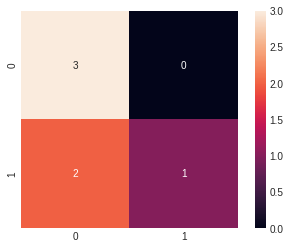

In [ ]:
#Check model accuracy on the test data
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

#Test a single image
n=2  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

#Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)

#############################################################
#Save all images classified as CE so we can fetch these images
#later and plot heatmaps.
########################################################
#Identify all images classified as parasitized
ce_image_idx = np.where(y_pred == 0)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_ce=[]
for i in ce_image_idx:
    ce_img = X_test[i]
    #plt.imsave("results_classified_as_ce/ce_"+str(i)+".png", par_img)
    predicted_as_ce.append(ce_img)
    
predicted_as_ce = np.array(predicted_as_ce)    


In [ ]:
X_test[3].shape

(224, 224, 3)

0
1
2


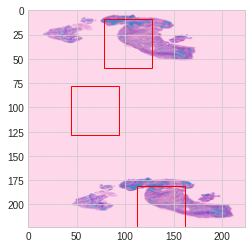

In [ ]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

import random 
im = random.randint(0,predicted_as_ce.shape[0]-1)
heat_map =plot_heatmap(predicted_as_ce[im])

img = predicted_as_ce[im]
plt.imshow(predicted_as_ce[im])

# Part II -  Use Openslide to pre-process WSI images

In [9]:
!sudo apt-get install openslide-tools
!sudo apt-get install
!python-openslide pip install openslide-python
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (201 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import pandas as pd
ce_list = os.listdir('/content/drive/MyDrive/Mayo/train/CE')
laa_list = os.listdir('/content/drive/MyDrive/Mayo/train/LAA')
print('# CE labelled images = ',len(ce_list), '\n# LAA labelled images = ', len(laa_list))
ce_name_list = [x[:8] for x in ce_list]
laa_name_list = [x[:8] for x in laa_list]
print('\n# of laa images to be proessed:', len(laa_list))
img_idx = list(range(58))

tmp = [img_idx,laa_list]
df = pd.DataFrame({'Img_n':img_idx, 'Img':laa_list})
#df.loc[df['Img']=='508589_0.tif']
df.loc[df['Img'].str.contains("1f018f_0", case=False)]

# CE labelled images =  63 
# LAA labelled images =  58

# of laa images to be proessed: 58


,Img_n,Img
0,0,1f018f_0.tif


In [ ]:
import shutil
for name in ce_name_list[:64]:
  print(name)

In [ ]:
for name in laa_name_list[4:5]:
  print(name)
  #tile_dir = '/content/drive/MyDrive/Mayo/train/ce_patch_' + ce_name_list[sl]
  #shutil.rmtree('/content/drive/MyDrive/Mayo/train/train_CE/' + name)
  #print(name, ' deleted')
  #os.listdir('/content/drive/MyDrive/Mayo/train/train_LAA/')

244aeb_1


#Pre-processing I - create directory and generate WSI tiles/patches
Image Pre-processsing using Openslide

In [11]:
#import pyvips
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import openslide
import numpy as np
import matplotlib.pyplot as plt

#data_dir_CE = '/content/drive/MyDrive/Mayo/train/CE'
data_dir_LAA = '/content/drive/MyDrive/Mayo/train/LAA'
#image = openslide.OpenSlide(os.path.join(data_dir, '0aaeb3_0.tif'))

# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
#patch = image.read_region((0,0), 0, (256, 256))

# Display the image
#display(patch)

# Close the opened slide after use
#image.close()

In [ ]:
#Load the slide file (wsi) into an object
def load_image(img_list):
  #for img in img_list:
    #sl_CE = openslide.OpenSlide(os.path.join(data_dir_CE, img))
    sl_LAA = openslide.OpenSlide(os.path.join(data_dir_LAA, img_list))
    yield sl_LAA #sl_CE

#for i, sl_CE, sl_LAA in enumerate(ce_list, laa_list):
for i, img in enumerate(laa_list):
  os.chdir(data_dir_LAA)
  #sl_ce_gen = load_image(ce_list)
  #sl_laa_gen = iter(laa_list)
  #slide_ce = next(sl_ce_gen)
  #slide_laa = next(sl_laa_gen)
  print('\nimg # :',i,'  ',img)
  slide_laa = open_slide(laa_list[i])
  slide_props = slide_laa.properties
  #print(slide_props)
  print('slide is:', slide_laa)
  #print("Vendor is:", slide_props['openslide.vendor'])
  #print("Pixel size of X in um is:", slide_props['openslide.mpp-x'])
  #print("Pixel size of Y in um is:", slide_props['openslide.mpp-y'])

  #Objective used to capture the image
  #objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
  #print("The objective power is: ", objective)

  # get slide dimensions for the level 0 - max resolution level
  slide_dims = slide_laa.dimensions
  print('dimension :',slide_dims)

  #Get a thumbnail of the image and visualize PIL image
  #slide_thumb_600 = slide_laa.get_thumbnail(size=(600, 600))
  #slide_thumb_600.show()

  #Convert thumbnail to numpy array
  #slide_thumb_600_np = np.array(slide_thumb_600)
  #plt.figure(figsize=(8,8))
  #plt.imshow(slide_thumb_600_np)    

  #Get slide dims at each level. Remember that whole slide images store information as pyramid at various levels
  dims = slide_laa.level_dimensions

  num_levels = len(dims)
  print("Number of levels in this image are:", num_levels)
  print("Dimensions of various levels in this image are:", dims)

  # get downsampled level
  factors = slide_laa.level_downsamples
  print("Each level is downsampled by an amount of: ", factors)

  #Copy an image from a level
  level1_dim = dims[0]
  print('level_dim :   ', level1_dim)
  #Give pixel coordinates (top left pixel in the original large image) and the level number (for level 1, value = 0)
  #get size of your output image to output would be a RGBA image (Not, RGB)

  #level1_img = slide_laa.read_region((0,0), 0, level1_dim) #Pillow object, mode=RGBA
  print('not created level1_img')
  #Convert the image to RGB
  #level1_img_RGB = level1_img.convert('RGB')
  #level1_img_RGB.show()
  print('not convert level1_img to RGB')

  #Convert the image into numpy array for processing
  #level1_img_np = np.array(level1_img_RGB)
  #plt.imshow(level1_img_np)

  #Return the best level for displaying the given downsample.
  SCALE_FACTOR = 32
  best_level = slide_laa.get_best_level_for_downsample(SCALE_FACTOR)
  # returns the best level to be 2 (third level)
  # change the scale factor to 2, it will suggest the best level to be 0 (our 1st level)

  #################################
  #Generating tiles for deep learning training or other processing purposes
  #use read_region function and slide over the large image to extract tiles or an easier approach would be to use DeepZoom based generator
  #Generate object for tiles using the DeepZoomGenerator by dividing tif into tiles of size 256 with no overlap. 
  tiles = DeepZoomGenerator(slide_laa, tile_size=256, overlap=0, limit_bounds=False)

  #check the number of levels
  tiles_level_ct = tiles.level_count
  print("The number of levels in the tiles object are: ", tiles_level_ct)
  print("The dimensions of data in each level are: ", tiles.level_dimensions)

  #Total number of tiles in the tiles object
  print("Total number of tiles = : ", tiles.tile_count)
  #How many tiles at a specific level?
  #************************************
  # level_num = 11
  # print("Tiles shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
  # print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], "total tiles in this level")

  #Dimensions of the tile (tile size) for a specific tile from a specific layer
  #tile_dims = tiles.get_tile_dimensions(11, (3,4)) #Provide deep zoom level and address (column, row)

  #Tile count at the highest resolution level (level 16 in our tiles)
  tile_count_in_large_image = tiles.level_tiles[tiles_level_ct-1] #126 x 151 (32001/256 = 126 with no overlap pixels)

  #Check tile size for some random tile
  n_row = round(slide_dims[0]//256)
  n_col = round(slide_dims[1]//256)
  print(n_row, n_col)
  
  last_tile = tiles_level_ct - 1
  tile_dims = tiles.get_tile_dimensions(last_tile, (n_row,n_col))
  #Last tiles may not have full 256x256 dimensions as our large image is not exactly divisible by 256
  print('last_tile dimension: ', tile_dims)
  single_tile = tiles.get_tile(last_tile, (18, 17)) #Provide deep zoom level and address (column, row)
  single_tile_RGB = single_tile.convert('RGB')
  single_tile_RGB.show()

  ###### Saving each tile to local subdirectory
  cols, rows = tiles.level_tiles[last_tile]

  # Subdirectory
  #ce_directory = ce_name_list[i]
  laa_directory = laa_name_list[i]

  # Parent Directory path
  #parent_dir_ce = '/content/drive/MyDrive/Mayo/train/train_CE'
  parent_dir_laa = '/content/drive/MyDrive/Mayo/train/train_LAA'
  
  # Path
  #tile_dir_ce = os.path.join(parent_dir_ce, ce_directory)
  tile_dir_laa = os.path.join(parent_dir_laa, laa_directory)
  
  # Create the directory
  #isExist = os.path.exists(tile_dir_ce)
  isExist = os.path.exists(tile_dir_laa)
  print('exist?', isExist)
  try:
    print('tile directory :', tile_dir_laa)
    os.mkdir(tile_dir_laa)
  except OSError as error:
    print(error)
  #tile_dir = '/content/drive/MyDrive/Mayo/train/ce_patch_' + ce_name_list[sl]
  for row in range(rows):
      for col in range(cols):
          #tile_name_ce = os.path.join(tile_dir_ce, '%d_%d' % (col, row))
          if not isExist:
            #tile_name_ce = os.path.join(tile_dir_ce, '%d_%d' % (col, row))
            tile_name_laa = os.path.join(tile_dir_laa, '%d_%d' % (col, row))
            #print("Now saving tile with title: ", tile_name_ce)
            print("Now saving tile with title: ", tile_name_laa)
            temp_tile = tiles.get_tile(last_tile, (col, row))
            temp_tile_RGB = temp_tile.convert('RGB')
            temp_tile_np = np.array(temp_tile_RGB)
            #plt.imsave(tile_name_ce + ".png", temp_tile_np)
            plt.imsave(tile_name_laa + ".png", temp_tile_np)
  print('\ni :', i)
          


In [ ]:
# Check for tile creation in subdirectories
import shutil
count=0
LAA_dir = '/content/drive/MyDrive/Mayo/train/train_LAA/'
for j in os.listdir(LAA_dir):
  cur_dir = LAA_dir+j
  print(cur_dir)
  #os.chdir(cur_dir)
  if len(os.listdir(cur_dir)) == 0:
    print(j,' is an empty subdir!')
    shutil.rmtree(cur_dir)
    print(cur_dir, ' deleted')
    print(os.path.exists(cur_dir))
  else:
    print(j, ' has ',len(os.listdir(cur_dir)), 'png files')
    count+=1
print('# of LAA images :', count)

In [25]:
# check for masked tile creation; E_tile, H_tile and nomalized_tile in subdir
count=0
LAA_dir = '/content/drive/MyDrive/Mayo/train/train_LAA/'
for j in os.listdir(LAA_dir):
  cur_dir = LAA_dir+j
  os.chdir(cur_dir)
  if len(os.listdir()) == 0:
    print(j,' is an empty subdir!')
    shutil.rmtree(cur_dir)
    print(cur_dir, ' deleted')
    print(os.path.exists(cur_dir))
  elif os.path.exists(cur_dir+'/H_tiles'):
    E_tile_dir = cur_dir+'/H_tiles'
    print(j,' H_tiles subdir exists?: ',os.path.exists(E_tile_dir))
  else:
    print(j, ' has ',len(os.listdir()), 'png files')
  count+=1
print('# of LAA images :', count)

1f018f_0  H_tiles subdir exists?:  True
244aeb_2  H_tiles subdir exists?:  True
113bb3_0  H_tiles subdir exists?:  True
2a25b9_0  H_tiles subdir exists?:  True
244aeb_1  H_tiles subdir exists?:  True
244aeb_0  H_tiles subdir exists?:  True
0bd414_0  H_tiles subdir exists?:  True
01adc5_0  H_tiles subdir exists?:  True
1db82d_0  H_tiles subdir exists?:  True
1db82d_1  H_tiles subdir exists?:  True
1ffc5d_0  H_tiles subdir exists?:  True
2b7304_0  H_tiles subdir exists?:  True
2b7304_1  H_tiles subdir exists?:  True
23b492_0  H_tiles subdir exists?:  True
162cad_0  H_tiles subdir exists?:  True
00c058_0  H_tiles subdir exists?:  True
0a3ad1_0  H_tiles subdir exists?:  True
0ee750_0  H_tiles subdir exists?:  True
3ee426_0  H_tiles subdir exists?:  True
481ba8_0  H_tiles subdir exists?:  True
497c27_0  H_tiles subdir exists?:  True
5588f9_0  H_tiles subdir exists?:  True
53845a_1  H_tiles subdir exists?:  True
54838a_0  H_tiles subdir exists?:  True
5adc4c_0  H_tiles subdir exists?:  True


In [ ]:
os.chdir('/content/drive/MyDrive/Mayo/train/train_LAA/34a278_0')
len(os.listdir())

714

Function to normalize and segment H&E stains in WSI images

In [16]:
# normalize H&E slides
import numpy as np
import cv2
from matplotlib import pyplot as plt

############### INPUT RGB IMAGE #######################
#Using opencv to read images may be more robust compared to using skimage
#but need to remember to convert BGR to RGB.
#Also, convert to float later on and normalize to between 0 and 1.

#Image downloaded from:
#https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
# img=cv2.imread('images/HnE_Image.jpg', 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
# alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
# beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


def norm_HnE(img, Io=240, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 
    
    OD = -np.log10((img.astype(float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
        
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

# img=cv2.imread('images/HnE_Image.jpg', 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# norm_img, H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)

# plt.imsave("images/HnE_normalized.jpg", Inorm)
# plt.imsave("images/HnE_separated_H.jpg", H)
# plt.imsave("images/HnE_separated_E.jpg", E)

In [ ]:
import shutil

src = "/content/drive/MyDrive/Mayo/train/blank/original_tiles_0aae3_0"
os.chdir(src)
ori_list = os.listdir(src)
dst = "/content/drive/MyDrive/Mayo/train/blank"
f_size = 30000
file_list = []
print('# of files :',len(ori_list))

for i in ori_list:
  filesize = os.path.getsize(i)
  
  if int(filesize) <= int(f_size):
     file_list.append(i)
print('# of files to be moved :',len(file_list))

for f in file_list:
  shutil.move(f, dst)
  print(' number of files moved')

# of files : 490
# of files to be moved : 0


In [ ]:
#import pyvips
from openslide import open_slide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff

#Load the slide file (svs) into an object.
#slide = open_slide(os.path.join(data_dir, '0ed87f_1.tif'))

# slide_props = slide.properties
# print(slide_props)

###############################################################################################################
#Extracting a small region and processing it
#267 - Processing whole slide images (as tiles)   - DigitalSreeni   https://www.youtube.com/watch?v=tNfcvgPKgyU

#Load a level image, normalize the image and digitally extract H and E images
#As described in video 122: https://www.youtube.com/watch?v=yUrwEYgZUsA
#from normalize_HnE import norm_HnE

#Extract a small region from the large file (level 0)
#Let us extract a region from somewhere in the middle - coords 16k, 16k
#Extract 1024,1024 region
smaller_region = slide_laa.read_region((18000,8000), 0, (1024,1024))
smaller_region_RGB = smaller_region.convert('RGB')
smaller_region_np = np.array(smaller_region_RGB)

plt.axis('off')
plt.imshow(smaller_region_np)

norm_img, H_img, E_img = norm_HnE(smaller_region_np, Io=240, alpha=1, beta=0.15)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(smaller_region_np)
plt.subplot(222)
plt.title('Normalized Image')
plt.imshow(norm_img)
plt.subplot(223)
plt.title('H image')
plt.imshow(H_img)
plt.subplot(224)
plt.title('E image')
plt.imshow(E_img)
plt.show()

#######################################################

#The way the HnE normalization code is written, it does not work for blank images.
#Also, it does not do a good job with very little regions.

#A few tiles were already saved and in the following exercise we will load them 
#to understand the mean and std. dev. in their pixel values. 
#We can then handle blank tiles and tiles with low sample region separately.

################################################################
#For blank it throws an Eigenvalues error.
#blank = cv2.imread("/content/drive/MyDrive/Mayo/train/ce_patch/0_0.png")
#norm_img, H_img, E_img = norm_HnE(blank, Io=240, alpha=1, beta=0.15)
################################################################

#Let us define a function to detect blank tiles and tiles with very minimal information
#This function can be used to identify these tiles so we can make a decision on what to do with them. 
#Here, the function calculates mean and std dev of pixel values in a tile. 
def find_mean_std_pixel_value(img_list):
    
    avg_pixel_value = []
    stddev_pixel_value= []
    for file in img_list:
        image = tiff.imread(file)
        avg = image.mean()
        std = image.std()
        avg_pixel_value.append(avg)
        stddev_pixel_value.append(std)
        
    avg_pixel_value = np.array(avg_pixel_value)  
    stddev_pixel_value=np.array(stddev_pixel_value)
        
    print("Average pixel value for all images is:", avg_pixel_value.mean())
    print("Average std dev of pixel value for all images is:", stddev_pixel_value.mean())
    
    return(avg_pixel_value, stddev_pixel_value)

#read some blank tiles, some partial tiles and some good ones to find out the mean and std dev of pixel values. 
#These numbers can be used to identify 'problematic' slides that we can bypass from our processing. 
import glob
orig_tile_dir_name = "/content/drive/MyDrive/Mayo/train/train_ce"

blank_img_list=(glob.glob(orig_tile_dir_name+"blank/*.png"))
partial_img_list=(glob.glob(orig_tile_dir_name+"partial/*.png"))
good_img_list=(glob.glob(orig_tile_dir_name+"good/*.png"))

blank_img_stats = find_mean_std_pixel_value(blank_img_list)
partial_img_stats = find_mean_std_pixel_value(partial_img_list)
good_img_stats = find_mean_std_pixel_value(good_img_list)

"""
Average pixel value for all blank images is: 244.45962306699482
Average std dev of pixel value for all blank images is: 0.9214953206879862
Average pixel value for all partial images is: 242.93900954932494
Average std dev of pixel value for all partial images is: 10.427143587023263
Average pixel value for all good images is: 208.8701055190142
Average std dev of pixel value for all good images is: 37.36282416278772
"""

##Pre-processing II - create subdirectories and store segmented normalized, E_tiles and H_tiles

In [ ]:
#use DeepZoom based generator to read_region function and slide over the large image to extract tiles.
# https://openslide.org/api/python/
from openslide.deepzoom import DeepZoomGenerator

#Load the slide file (wsi) into an object
def load_image(img_list):
  for img in img_list:
    print(img)
    #sl_CE = openslide.OpenSlide(os.path.join(data_dir_CE, img))
    sl_LAA = openslide.OpenSlide(os.path.join(data_dir_LAA, img))
    yield sl_LAA

for i, sl in enumerate(laa_list):
  sl_gen = load_image(laa_list)
  slide = next(sl_gen)

  #Generate object for tiles using the DeepZoomGenerator with tile size of 256bytes
  tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)

  #check the number of levels in tile object
  print("The number of levels in the tiles object are: ", tiles.level_count)
  print("The dimensions of data in each level are: ", tiles.level_dimensions)
  print("Total number of tiles = : ", tiles.tile_count)

  #processing and saving each tile to local directory
  cols, rows = tiles.level_tiles[15]
  #parent_dir_ce = '/content/drive/MyDrive/Mayo/train/train_CE/'+ce_name_list[i]
  parent_dir_laa = '/content/drive/MyDrive/Mayo/train/train_LAA/'+laa_name_list[i]
  #create tile type subdirectories
  #print(parent_dir_ce+'/normalized_tiles')
  print(parent_dir_laa+'/normalized_tiles')
  try:
    #os.mkdir(parent_dir_ce)
    os.mkdir(parent_dir_laa)
  except:
    print('parent directory already exists')
    pass
  try:
    #os.mkdir(parent_dir_ce +'/normalized_tiles')
    os.mkdir(parent_dir_laa +'/normalized_tiles')
  except:
    print('normalized subdirectory already exists')
    pass
  try:
    #os.mkdir(parent_dir_ce +'/H_tiles')
    os.mkdir(parent_dir_laa +'/H_tiles')
  except:
    print('H subdirectory already exists')
    pass
  try:
    #os.mkdir(parent_dir_ce +'/E_tiles')
    os.mkdir(parent_dir_laa +'/E_tiles')
  except:
    print('E subdirectory already exists')
    pass    

  #orig_tile_dir_name = "/content/drive/MyDrive/Mayo/train/ce_patch_temp/"
  #norm_tile_dir_name = parent_dir_ce + "/normalized_tiles/"
  #H_tile_dir_name = parent_dir_ce + "/H_tiles/"
  #E_tile_dir_name = parent_dir_ce + "/E_tiles/"
  norm_tile_dir_name = parent_dir_laa + "/normalized_tiles/"
  H_tile_dir_name = parent_dir_laa + "/H_tiles/"
  E_tile_dir_name = parent_dir_laa + "/E_tiles/"

  for row in range(rows):
      for col in range(cols):
          tile_name = str(col) + "_" + str(row)
          #tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
          #print("Now processing tile with title: ", tile_name)
          temp_tile = tiles.get_tile(15, (col, row))
          temp_tile_RGB = temp_tile.convert('RGB')
          temp_tile_np = np.array(temp_tile_RGB)
          #Save original tile
          #plt.imsave(orig_tile_dir_name+tile_name + ".png", temp_tile_np)
          #print('processing CE WSI image >>>>', ce_name_list[i])
          print('processing LAA WSI image >>>>', laa_name_list[i])
          if temp_tile_np.mean() < 220 and temp_tile_np.std() > 15:
              print("Processing tile number:", tile_name)
              norm_img, H_img, E_img = norm_HnE(temp_tile_np, Io=240, alpha=1, beta=0.15)

              #Save the norm tile, H and E tiles
              exist_norm = os.path.exists(norm_tile_dir_name+tile_name + "_norm.png")
              exist_H = os.path.exists(norm_tile_dir_name+tile_name + "_H.png")
              exist_E = os.path.exists(norm_tile_dir_name+tile_name + "_E.png")
              if exist_norm or exist_H or exist_E:
                print('file already exists)')
              else:
                plt.imsave(norm_tile_dir_name+tile_name + "_norm.png", norm_img)
                plt.imsave(H_tile_dir_name+tile_name + "_H.png", H_img)
                plt.imsave(E_tile_dir_name+tile_name + "_E.png", E_img)
              
          else:
              print("NOT PROCESSING TILE:", tile_name)
    

# Feature Engineering Steps

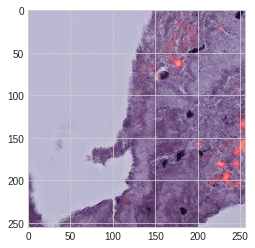

In [ ]:
img = plt.imread("/content/drive/MyDrive/Mayo/train/train_CE/2e3749_0/normalized_tiles/10_65_norm.png")
plt.imshow(img, cmap="gray")
#new_img= remove_bkgd()


  0%|          | 0/3 [00:00<?, ?it/s]

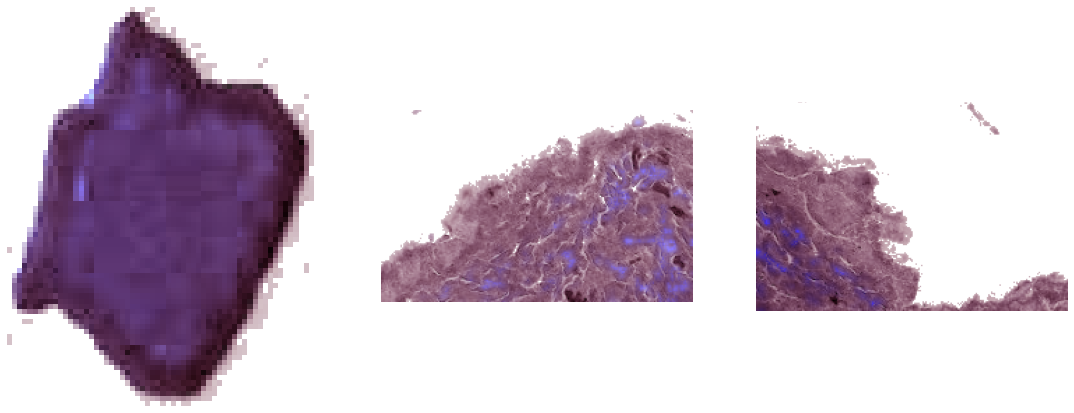

In [ ]:
X = []
y = []
os.chdir('/content/drive/MyDrive/Mayo/train/train_CE/2e3749_0/normalized_tiles/')
norm_dir = os.listdir()
for i in tqdm(norm_dir[:3]):
      img = cv2.imread(i)   
      img = cv2.resize(img,(224,224))      #<=== resize image to 224x224 pixels
      y.append(img)
      img, mask = mask_filter(np.array(img))
      img = remove_bkgd(img, mask)
      X.append(img)

plt.figure(figsize=(19, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X[i], cmap="gray")    
    plt.axis('off')

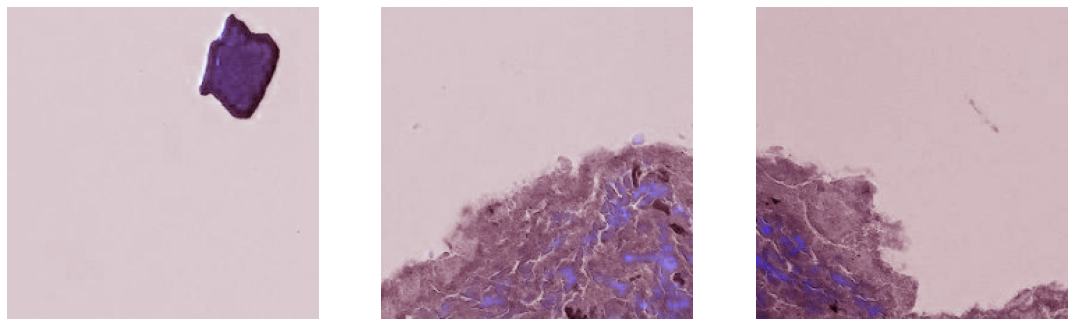

In [ ]:
plt.figure(figsize=(19, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(y[i], cmap="gray")
    plt.axis('off')